In [1]:
import gpytorch
import torch

from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from gpytorch.priors import UniformPrior
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal

class GaussianProcessConstant(gpytorch.models.ExactGP):
    def __init__(self, x, y, likelihood, device, mean_constant=0.0, lengthscale=1.0, outputscale=1.0, noise=0.1):
        super().__init__(x, y, likelihood)
        self.device = device

        # Initialize mean module
        self.mean_module = ConstantMean()
        self.mean_module.constant = mean_constant
        self.covar_module = ScaleKernel(
            RBFKernel()
        )
        self.covar_module.base_kernel.lengthscale = lengthscale
        self.covar_module.outputscale = outputscale
        # Set noise
        self.likelihood = likelihood
        self.likelihood.noise_covar.noise = noise

        # Move to the specified device
        self.to(device)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

class GPSamplerConstant:
    def __init__(self, dimension=5, seed=None, mean_constant=0.0, length_scale=1.0, output_scale=1.0, noise=0.1):
        # Initialize likelihood and gp with configurable parameters
        self.likelihood = GaussianLikelihood()
        self.likelihood.eval()
        self.gp = GaussianProcessConstant(None, None, self.likelihood, mean_constant, length_scale, output_scale, noise)
        self.gp.eval()

        self.dim = dimension
        self.seed = seed
        if seed is not None:
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

    def sample(self, max_num_points=512, x_range=(-2, 2)):
        lb, ub = x_range
        x = lb + (ub - lb) * torch.rand([max_num_points, self.dim])
        y = self.likelihood(self.gp(x)).sample().unsqueeze(-1)

        return x,y


In [2]:
import torch
from torch.utils.data import Dataset
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from gpytorch.distributions import MultivariateNormal

class GaussianProcessConstant(ExactGP):
    def __init__(self, x, y, likelihood, mean_constant=0.0, lengthscale=1.0, outputscale=1.0, noise=0.1):
        super().__init__(x, y, likelihood)
        self.mean_module = ConstantMean()
        self.mean_module.constant = mean_constant
        self.covar_module = ScaleKernel(RBFKernel())
        self.covar_module.base_kernel.lengthscale = lengthscale
        self.covar_module.outputscale = outputscale
        self.likelihood = likelihood
        self.likelihood.noise_covar.noise = noise

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

class GPSamplerConstantDataset(Dataset):
    def __init__(self, num_samples, dimension=1, mean_constant=0.0, length_scale=0.5, output_scale=1.0, noise=0.1, x_range=(-3, 3), horizon=100, seed=None):
        self.num_samples = num_samples
        self.dimension = dimension
        self.x_range = x_range
        self.horizon = horizon

        if seed is not None:
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
        
        self.likelihood = GaussianLikelihood()
        self.gp = GaussianProcessConstant(None, None, self.likelihood, mean_constant, length_scale, output_scale, noise)
        self.gp.eval()
        self.likelihood.eval()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        lb, ub = self.x_range
        x = lb + (ub - lb) * torch.rand([self.horizon, self.dimension])
        y = self.likelihood(self.gp(x)).sample().unsqueeze(-1)
        return x, y

dataset = GPSamplerConstantDataset(num_samples=100, dimension=1, mean_constant=0.0, length_scale=0.5, output_scale=1.0, noise=0.1, horizon=100)

for x, y in dataset:
    print(x.shape, y.shape)
    break

torch.Size([100, 1]) torch.Size([100, 1])


In [3]:
from torch.utils.data import DataLoader
from collections import namedtuple
Rawdata = namedtuple('Rawdata', ['x', 'y'])

test_dataset = GPSamplerConstantDataset(
    num_samples=100, 
    dimension=1, 
    horizon=5)

def scalar_collate_fn(batch):
    x, y = zip(*batch)
    x = torch.stack(x, dim=0)
    y = torch.stack(y, dim=0)
    return Rawdata(x, y)

test_dataset = GPSamplerConstantDataset(
    num_samples=100, 
    dimension=1, 
    horizon=5)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=scalar_collate_fn)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import sys
sys.path.append('..')
from models.modules import build_mlp
from collections import namedtuple


class RiemannDistribution(nn.Module):
    def __init__(self, borders, accelerator = None):
        super().__init__()
        assert len(borders.shape) == 1, "Borders should be a 1D tensor."
        self.accelerator = accelerator
        self.register_buffer('borders', borders)
        self.register_buffer('bucket_widths', borders[1:] - borders[:-1])
        self.num_buckets = len(borders) - 1

    def map_to_bucket_idx(self, y):
        # Map each target value y to its corresponding bucket index
        target_sample = torch.searchsorted(self.borders, y, right=False) - 1
        target_sample = target_sample.clamp(0, self.num_buckets - 1)
        return target_sample

    def forward(self, logits, y):
        # logits: (batch_size, seq_len, num_buckets)
        # y: (batch_size, seq_len)
        target_sample = self.map_to_bucket_idx(y)  # (batch_size, seq_len)
        bucket_log_probs = F.log_softmax(logits, dim=-1)  # (batch_size, seq_len, num_buckets)
        log_bucket_widths = torch.log(self.bucket_widths)  # (num_buckets,)
        scaled_log_probs = bucket_log_probs - log_bucket_widths  # Broadcasting over num_buckets
        # Gather the log probabilities for the target buckets
        log_probs = scaled_log_probs.gather(-1, target_sample.unsqueeze(-1)).squeeze(-1)  # (batch_size, seq_len)
        # Compute the negative log-likelihood loss
        loss = -log_probs.mean()
        return log_probs, loss

    def sample(self, logits):

        bucket_indices = torch.distributions.Categorical(logits=logits).sample()  # (batch_size, seq_len)
        # Sample uniformly within the bucket
        bucket_lefts = self.borders[:-1][bucket_indices]  # (batch_size, seq_len)
        bucket_rights = self.borders[1:][bucket_indices]  # (batch_size, seq_len)
        samples = bucket_lefts + (bucket_rights - bucket_lefts) * torch.rand_like(bucket_lefts)
        return samples

class ExCg_Model(nn.Module):
    def __init__(
        self,
        model_args,
        accelerator = None,
):
        super(ExCg_Model, self).__init__()
        self.accelerator = accelerator
        self.setup_configuration(model_args)
        self.setup_embedder()
        self.setup_transformer()
        self.setup_predictor()
        self.setup_gradient()
        self.print_gradient_status()

    def setup_configuration(self, model_args):
        self.dim_llm_embedding = model_args.dim_llm_embedding
        self.dim_y = model_args.dim_y
        self.d_model = model_args.d_model
        self.dim_feedforward = model_args.dim_feedforward
        self.nhead = model_args.nhead
        self.emb_depth = model_args.emb_depth
        self.dropout = model_args.dropout
        self.activation = model_args.activation
        self.num_layers = model_args.num_layers
        self.embed_type = model_args.embed_type
        self.bound_std = model_args.bound_std
        self.pad_value = model_args.pad_value
        self.loss_type = model_args.loss_type
        self.uncertainty = model_args.uncertainty
        self.gradient_type = model_args.gradient_type
        self.borders_data = torch.load(model_args.borders_data_dir, weights_only=True) if model_args.borders_data_dir is not None else None
        self.num_buckets = len(self.borders_data) - 1 if self.borders_data is not None else None

    def setup_embedder(self):
        if self.embed_type == 'embed_llm_embedding':
            if self.emb_depth == 0:
                self.embedder = nn.Linear(self.dim_llm_embedding, self.d_model-self.dim_y)
            else:
                self.embedder = build_mlp(self.dim_llm_embedding, self.dim_feedforward, self.d_model - self.dim_y, self.emb_depth)

        elif self.embed_type == 'embed_concat':
            if self.emb_depth == 0:
                self.embedder = nn.Linear(self.dim_llm_embedding + self.dim_y, self.d_model)
            else:
                self.embedder = build_mlp(self.dim_llm_embedding + self.dim_y, self.dim_feedforward, self.d_model, self.emb_depth)

    def setup_predictor(self):
        if self.uncertainty == 'normal':
            if self.emb_depth == 0:
                self.mean_predictor = nn.Linear(self.d_model, self.dim_y)
                self.std_predictor = nn.Linear(self.d_model, self.dim_y)
            else:
                self.mean_predictor = build_mlp(self.d_model, self.dim_feedforward, self.dim_y, self.emb_depth)
                self.std_predictor = build_mlp(self.d_model, self.dim_feedforward, self.dim_y, self.emb_depth)
            
        elif self.uncertainty == 'riemann':
            if self.emb_depth == 0:
                self.bucket_predictor = nn.Linear(self.d_model, self.num_buckets)
            else:
                self.bucket_predictor = build_mlp(
                    self.d_model, self.dim_feedforward, self.num_buckets, self.emb_depth)
            
            self.setup_distribution()
        else:
            if self.emb_depth == 0:
                self.mean_predictor = nn.Linear(self.d_model, self.dim_y)
            else:
                self.mean_predictor = build_mlp(self.d_model, self.dim_feedforward, self.dim_y, self.emb_depth)

    def setup_distribution(self):
        # Define bucket borders and initialize RiemannDistribution
        self.register_buffer('borders', self.borders_data)
        self.register_buffer('bucket_widths', self.borders_data[1:] - self.borders_data[:-1])
        self.riemann_distribution = RiemannDistribution(self.borders_data, self.accelerator)

    def setup_transformer(self):
        encoder_layer = nn.TransformerEncoderLayer(d_model = self.d_model, 
                                                   nhead = self.nhead,
                                                   dim_feedforward = self.dim_feedforward,
                                                   dropout = self.dropout,
                                                   activation = self.activation,
                                                   batch_first=True)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, self.num_layers)

    def set_requires_grad(self,module, requires_grad):
        if isinstance(module, nn.Linear):
            module.weight.requires_grad = requires_grad
            module.bias.requires_grad = requires_grad
        elif isinstance(module, nn.Sequential):
            for layer in module:
                if isinstance(layer, nn.Linear):
                    layer.weight.requires_grad = requires_grad
                    layer.bias.requires_grad = requires_grad

    def setup_gradient(self):

        if self.gradient_type == 'mean':
            self.set_requires_grad(self.mean_predictor, True)
            self.set_requires_grad(self.std_predictor, False)
        elif self.gradient_type == 'std':
            for param in self.parameters():
                        param.requires_grad = False
                    # Only set std_predictor to True
            self.set_requires_grad(self.std_predictor, True)

    def print_gradient_status(self):
        if self.accelerator is not None:
            self.accelerator.print("Gradient status for each parameter:")
            for name, param in self.named_parameters():
                self.accelerator.print(f"{name}: requires_grad = {param.requires_grad}")


    def construct_excg_input(self, x, y):
        model_dtype = next(self.encoder.parameters()).dtype

        if model_dtype != x.dtype:
            x = x.to(model_dtype)
            y = y.to(model_dtype)   

        # split the data into context and target. The split is a random split
        n = x.shape[1]
        num_ctx = n - torch.randint(low=1, high=n-1, size=(1,)).item()

        xc, yc = x[:, :num_ctx], y[:, :num_ctx]
        xt, yt = x[:, num_ctx:], y[:, num_ctx:]

        x_y_ctx = torch.cat((xc, yc), dim=-1) 
        x_0_tar = torch.cat((xt, torch.zeros_like(yt)), dim=-1)

        raw_inp = torch.cat((x_y_ctx, x_0_tar), dim=1)
        embeddings = self.embedder(raw_inp)

        return xc, yc, xt, yt, embeddings 

    def create_excg_mask(self, num_ctx, num_tar):

        num_all = num_ctx + num_tar
        mask = torch.zeros(num_all, num_all).fill_(float('-inf'))
        mask[:, :num_ctx] = 0.0
        mask.diagonal().fill_(0.0)
        return mask

    def forward(self, batch):
        x = batch.x
        y = batch.y

        device = next(self.encoder.parameters()).device
        xc, yc, xt, yt, embeddings = self.construct_excg_input(x, y)
        mask = self.create_excg_mask(xc.shape[1], xt.shape[1])
        mask = mask.to(embeddings.dtype)

        encoding = self.encoder(embeddings, mask=mask)
        prediction = encoding[:, -xt.shape[1]:, :]
        
        if self.uncertainty == 'normal':

            mean = self.mean_predictor(prediction)
            std = self.std_predictor(prediction)
            if mean.dtype != yt.dtype:
                    yt = yt.to(mean.dtype)

            if self.bound_std:
                std = 0.05 + 0.95 * F.softplus(std)
            else:
                std = std = torch.exp(std)

            pred_dist = Normal(mean, std)

            if self.loss_type == 'logprob':
                loss = - pred_dist.log_prob(yt).sum(-1).mean()
            
            elif self.loss_type == 'mse':
                sample = pred_dist.rsample()
                loss = F.mse_loss(sample, yt)

        elif self.uncertainty == 'riemann':
            logits = self.bucket_predictor(prediction)  # (batch_size, seq_len, num_buckets)

            y = yt.squeeze()

            _, loss = self.riemann_distribution(logits, y)

            return loss

        else:
            out = self.mean_predictor(prediction)
            if out.dtype != yt.dtype:
                yt = yt.to(out.dtype)
            loss = F.mse_loss(out, yt)

        return loss
    
    def evaluate(self, batch):
        '''
        For evaluation, this is basically the same as forward, but besides loss, we still want to calculate the mean loss, and sample a point out, and the loss with the true target, and record the mean of std per step.
        So lets say we have x1:t and y1:t, we want to see the plot the std over all data and batch over time t. So when we use wandb log, we will create a diagram for every evaluation step, and that diagram will show the std over sequence t.
        '''

        x = batch.x
        y = batch.y

        device = next(self.encoder.parameters()).device
        xc, yc, xt, yt, embeddings = self.construct_excg_input(x, y)
        mask = self.create_excg_mask(xc.shape[1], xt.shape[1])
        mask = mask.to(embeddings.dtype)

        encoding = self.encoder(embeddings, mask=mask)
        prediction = encoding[:, -xt.shape[1]:, :]

        if self.uncertainty == 'normal':

            mean = self.mean_predictor(prediction)
            std = self.std_predictor(prediction)
            if mean.dtype != yt.dtype:
                    yt = yt.to(mean.dtype)

            if self.bound_std:
                std = 0.05 + 0.95 * F.softplus(std)
            else:
                std = std = torch.exp(std)

            pred_dist = Normal(mean, std)
            sample = pred_dist.sample()
            sample_loss = F.mse_loss(sample, yt, reduction='none')
            mean_loss = F.mse_loss(mean, yt, reduction='none')

            std_list = std.mean(dim=-1).mean(dim = 0)
            log_prob_list = pred_dist.log_prob(yt).mean(dim=-1).mean(dim = 0)
            sample_loss_list = sample_loss.mean(dim=-1).mean(dim = 0)
            mean_list = mean_loss.mean(dim=-1).mean(dim = 0)
            std_mean = std_list.mean()
            log_prob_mean = log_prob_list.mean()
            sample_loss_mean = sample_loss_list.mean()
            mean_loss_mean = mean_list.mean()
        
        elif self.uncertainty == 'riemann':
            logits = self.bucket_predictor(prediction)
            yt = yt.squeeze()

            # Compute loss
            log_probs, loss = self.riemann_distribution(logits, yt)
            samples = self.riemann_distribution.sample(logits)

            # Compute mean predictions for MSE
            bucket_probs = F.softmax(logits, dim=-1)  # (batch_size, seq_len, num_buckets)
            bucket_lefts = self.borders[:-1]  # (num_buckets,)
            bucket_rights = self.borders[1:]  # (num_buckets,)
            bucket_centers = (bucket_lefts + bucket_rights) / 2  # (num_buckets,)
            mean_predictions = torch.sum(bucket_probs * bucket_centers, dim=-1)  # (batch_size, seq_len)

            mean_loss = F.mse_loss(mean_predictions, yt.view(mean_predictions.shape), reduction='none')
            mean_list = mean_loss.mean(dim = 0)
            sample_loss = F.mse_loss(samples, yt.view(samples.shape), reduction='none')
            sample_loss_list = sample_loss.mean(dim = 0)
            std_list = torch.zeros(yt.shape[1], device=device)
            log_prob_list = log_probs.mean(dim = 0)

            std_mean = std_list.mean()
            log_prob_mean = log_prob_list.mean()
            sample_loss_mean = sample_loss_list.mean()
            mean_loss_mean = mean_list.mean()

        return std_list, log_prob_list, sample_loss_list, mean_list, std_mean, log_prob_mean, sample_loss_mean, mean_loss_mean
        
    
    def construct_prediction_input(self, batch):
        xc = batch.xc
        yc = batch.yc
        xt = batch.xt
        yt = batch.yt

        model_dtype = next(self.encoder.parameters()).dtype
        if model_dtype != xc.dtype:
            xc = xc.to(model_dtype)
            yc = yc.to(model_dtype)
            xt = xt.to(model_dtype)
            yt = yt.to(model_dtype)

        x_y_ctx = torch.cat((xc, yc), dim=-1) 
        x_0_tar = torch.cat((xt, torch.zeros_like(yt)), dim=-1)

        raw_inp = torch.cat((x_y_ctx, x_0_tar), dim=1)
        embeddings = self.embedder(raw_inp)

        return embeddings
    
    def create_prediction_mask(self, batch):
        num_ctx = batch.xc.shape[1]
        num_tar = batch.xt.shape[1]
        num_all = num_ctx + num_tar

        mask = torch.zeros(num_all, num_all).fill_(float('-inf'))
        mask.diagonal().fill_(0.0)

        # Make context points autoregressive
        for i in range(num_ctx):
            mask[i, :i+1] = 0.0
        
        # Allow target points to see all context points and themselves
        for i in range(num_ctx, num_all):
            mask[i, :num_ctx] = 0.0  # See all context points
            mask[i, i] = 0.0  # See itself
    
        return mask

    def predict(self, batch):
        xt = batch.xt
        yt = batch.yt
        device = next(self.encoder.parameters()).device

        embeddings = self.construct_prediction_input(batch)
        mask = self.create_prediction_mask(batch)
        mask = mask.to(embeddings.dtype)
        mask = mask.to(device)

        encoding = self.encoder(embeddings, mask=mask)
        prediction = encoding[:, -xt.shape[1]:, :]

        if self.uncertainty == 'normal':

            mean = self.mean_predictor(prediction)
            std = self.std_predictor(prediction)

            if self.bound_std:
                std = 0.05 + 0.95 * F.softplus(std)
            else:
                std = std = torch.exp(std)

            pred_dist = Normal(mean, std)
            sample = pred_dist.sample()

        elif self.uncertainty == 'riemann':
            logits = self.bucket_predictor(prediction)  # (batch_size, num_tar, num_buckets)
            sample = self.riemann_distribution.sample(logits).unsqueeze(-1)  # 
        else: 
            sample = self.mean_predictor(prediction)
        
        return sample

    

In [5]:
import sys
sys.path.append('..')
import torch
from accelerate import Accelerator
import os
from dataclasses import dataclass, field
from transformers import HfArgumentParser
import torch
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
import torch
import os
from dataclasses import dataclass, field
import yaml
import torch
from types import SimpleNamespace
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.distributions as dist
import torch.multiprocessing as mp
import json
from tqdm import tqdm
from functools import partial
import torch.nn as nn
import math
import gpytorch
import torch.optim as optim

os.environ['NCCL_P2P_LEVEL'] = 'NVL'

@dataclass
class ModelArguments:
    dim_llm_embedding: int = field(default=1024)
    dim_y: int = field(default=1)
    repeat_y: int = field(default=1)
    emb_depth: int = field(default=0)
    d_model: int = field(default=2048)
    dim_feedforward: int = field(default=5120)
    nhead: int = field(default=256)
    dropout: float = field(default=0.2)
    activation: str = field(default="gelu")
    num_layers: int = field(default=4)
    bound_std: bool = field(default=True)
    embed_type: str = field(default="embed_concat")
    uncertainty: str = field(default="normal")
    loss_type: str = field(default="logprob")
    pad_value: float = field(default=0.0)
    gradient_type: str = field(default="full")
    borders_data_dir: str = field(default=None)
    model_type: str = field(default="autoreg")

/user/al4263/.conda/envs/llm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

from models.modules import build_mlp
from collections import namedtuple


class RiemannDistribution(nn.Module):
    def __init__(self, borders, accelerator = None):
        super().__init__()
        assert len(borders.shape) == 1, "Borders should be a 1D tensor."
        self.accelerator = accelerator
        self.register_buffer('borders', borders)
        self.register_buffer('bucket_widths', borders[1:] - borders[:-1])
        self.num_buckets = len(borders) - 1

    def map_to_bucket_idx(self, y):
        # Map each target value y to its corresponding bucket index
        target_sample = torch.searchsorted(self.borders, y, right=False) - 1
        target_sample = target_sample.clamp(0, self.num_buckets - 1)
        return target_sample

    def forward(self, logits, y):
        # logits: (batch_size, seq_len, num_buckets)
        # y: (batch_size, seq_len)
        target_sample = self.map_to_bucket_idx(y)  # (batch_size, seq_len)
        bucket_log_probs = F.log_softmax(logits, dim=-1)  # (batch_size, seq_len, num_buckets)
        log_bucket_widths = torch.log(self.bucket_widths)  # (num_buckets,)
        scaled_log_probs = bucket_log_probs - log_bucket_widths  # Broadcasting over num_buckets
        # Gather the log probabilities for the target buckets
        log_probs = scaled_log_probs.gather(-1, target_sample.unsqueeze(-1)).squeeze(-1)  # (batch_size, seq_len)
        # Compute the negative log-likelihood loss
        loss = -log_probs.mean()
        return log_probs, loss

    def sample(self, logits):

        bucket_indices = torch.distributions.Categorical(logits=logits).sample()  # (batch_size, seq_len)
        # Sample uniformly within the bucket
        bucket_lefts = self.borders[:-1][bucket_indices]  # (batch_size, seq_len)
        bucket_rights = self.borders[1:][bucket_indices]  # (batch_size, seq_len)
        samples = bucket_lefts + (bucket_rights - bucket_lefts) * torch.rand_like(bucket_lefts)
        return samples

class Autoreg_Model(nn.Module):
    def __init__(
        self,
        model_args,
        accelerator = None,
):
        super(Autoreg_Model, self).__init__()
        self.accelerator = accelerator
        self.setup_configuration(model_args)
        self.setup_embedder()
        self.setup_transformer()
        self.setup_predictor()
        self.setup_gradient()
        self.print_gradient_status()

    def setup_configuration(self, model_args):
        self.dim_llm_embedding = model_args.dim_llm_embedding
        self.dim_y = model_args.dim_y
        self.d_model = model_args.d_model
        self.dim_feedforward = model_args.dim_feedforward
        self.nhead = model_args.nhead
        self.emb_depth = model_args.emb_depth
        self.dropout = model_args.dropout
        self.activation = model_args.activation
        self.num_layers = model_args.num_layers
        self.embed_type = model_args.embed_type
        self.bound_std = model_args.bound_std
        self.pad_value = model_args.pad_value
        self.loss_type = model_args.loss_type
        self.uncertainty = model_args.uncertainty
        self.gradient_type = model_args.gradient_type
        self.borders_data = torch.load(model_args.borders_data_dir, weights_only=True) if model_args.borders_data_dir is not None else None
        self.num_buckets = len(self.borders_data) - 1 if self.borders_data is not None else None

    def setup_embedder(self):
        if self.embed_type == 'embed_llm_embedding':
            if self.emb_depth == 0:
                self.embedder = nn.Linear(self.dim_llm_embedding, self.d_model-self.dim_y)
            else:
                self.embedder = build_mlp(self.dim_llm_embedding, self.dim_feedforward, self.d_model - self.dim_y, self.emb_depth)

        elif self.embed_type == 'embed_concat':
            if self.emb_depth == 0:
                self.embedder = nn.Linear(self.dim_llm_embedding + self.dim_y, self.d_model)
            else:
                self.embedder = build_mlp(self.dim_llm_embedding + self.dim_y, self.dim_feedforward, self.d_model, self.emb_depth)

    def setup_predictor(self):
        if self.uncertainty == 'normal':
            if self.emb_depth == 0:
                self.mean_predictor = nn.Linear(self.d_model, self.dim_y)
                self.std_predictor = nn.Linear(self.d_model, self.dim_y)
            else:
                self.mean_predictor = build_mlp(self.d_model, self.dim_feedforward, self.dim_y, self.emb_depth)
                self.std_predictor = build_mlp(self.d_model, self.dim_feedforward, self.dim_y, self.emb_depth)
            
        elif self.uncertainty == 'riemann':
            if self.emb_depth == 0:
                self.bucket_predictor = nn.Linear(self.d_model, self.num_buckets)
            else:
                self.bucket_predictor = build_mlp(
                    self.d_model, self.dim_feedforward, self.num_buckets, self.emb_depth)
            
            self.setup_distribution()
        else:
            if self.emb_depth == 0:
                self.mean_predictor = nn.Linear(self.d_model, self.dim_y)
            else:
                self.mean_predictor = build_mlp(self.d_model, self.dim_feedforward, self.dim_y, self.emb_depth)

    def setup_distribution(self):
        # Define bucket borders and initialize RiemannDistribution
        self.register_buffer('borders', self.borders_data)
        self.register_buffer('bucket_widths', self.borders_data[1:] - self.borders_data[:-1])
        self.riemann_distribution = RiemannDistribution(self.borders_data, self.accelerator)

    def setup_transformer(self):
        encoder_layer = nn.TransformerEncoderLayer(d_model = self.d_model, 
                                                   nhead = self.nhead,
                                                   dim_feedforward = self.dim_feedforward,
                                                   dropout = self.dropout,
                                                   activation = self.activation,
                                                   batch_first=True)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, self.num_layers)

    def set_requires_grad(self,module, requires_grad):
        if isinstance(module, nn.Linear):
            module.weight.requires_grad = requires_grad
            module.bias.requires_grad = requires_grad
        elif isinstance(module, nn.Sequential):
            for layer in module:
                if isinstance(layer, nn.Linear):
                    layer.weight.requires_grad = requires_grad
                    layer.bias.requires_grad = requires_grad

    def setup_gradient(self):

        if self.gradient_type == 'mean':
            self.set_requires_grad(self.mean_predictor, True)
            self.set_requires_grad(self.std_predictor, False)
        elif self.gradient_type == 'std':
            for param in self.parameters():
                        param.requires_grad = False
                    # Only set std_predictor to True
            self.set_requires_grad(self.std_predictor, True)

    def print_gradient_status(self):
        if self.accelerator is not None:
            self.accelerator.print("Gradient status for each parameter:")
            for name, param in self.named_parameters():
                self.accelerator.print(f"{name}: requires_grad = {param.requires_grad}")

    def construct_causal_input(self, x, y):

        '''
        For the decoder style input, we basically just stack all (xi,yi) pair and (x0, y0) pair together.
        For context points, we stack till i = n-1, and for prediction points, we stack all n prediction points together.
        '''

        model_dtype = next(self.encoder.parameters()).dtype

        # accelerator check x y shape:
        # self.accelerator.print(f'x shape: {x.shape}, y shape: {y.shape}')

        if model_dtype != x.dtype:
            x = x.to(model_dtype)
            y = y.to(model_dtype)

        if self.embed_type == 'embed_llm_embedding':
            x = self.embedder(x)

        # y = y.repeat(1, 1)
        # y_noise = y + 0.05 * torch.randn_like(y)
        xy =  torch.cat((x, y), dim=-1)
        
        # remove the last step of xy because it will never be used:
        xy = xy[:, :-1, :]

        x0 = torch.cat((x, torch.full_like(y, self.pad_value)), dim=-1)
        raw_inp = torch.cat((xy, x0), dim=1)
        raw_inp = raw_inp.to(next(self.encoder.parameters()).device)
        embeddings = self.embedder(raw_inp)

        return embeddings 

    def create_causal_mask(self, n):
        '''
        n here is the length of sequence x1:n

        For causal mask, we want to assume previous context points (xi,yi) cannot attend to the future context points (xi+1, yi+1), 
        but only to the previous context points and it self (x1:i, y1:i)

        For prediction (xi, 0), we attend to previous context points (x1:i-1, y1:i-1) and the prediction point it self (xi, 0)

        For (xn,yn), no one attends to it, so we don't even include it in the mask

        The mask is of shape (2n-1, 2n-1) because we have n-1 context points and n prediction points

        For example, if n = 4, the mask is a 7 x 7 matrix:

        [[0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, 0., -inf, -inf, -inf],
        [0., -inf, -inf, -inf, 0., -inf, -inf],
        [0., 0., -inf, -inf, -inf, 0., -inf],
        [0., 0., 0., -inf, -inf, -inf, 0.]]

        '''

        mask = torch.triu(torch.full((2*n-1, 2*n-1), float("-inf")), diagonal=1)
        for i in range(n-1, 2*n-1):
            mask[i, i-n+1:i] = float("-inf")

        mask = mask.to(next(self.encoder.parameters()).device)
        return mask
    
    def create_causal_pred_mask(self, n):
        '''
        This is just the standard causal mask like a LLM
        '''

        mask = torch.triu(torch.full((n, n), float("-inf")), diagonal=1)
        mask = mask.to(next(self.encoder.parameters()).device)

        return mask

    def forward(self, batch):
        x = batch.x
        y = batch.y

        device = next(self.encoder.parameters()).device
        x = x.to(device)
        y = y.to(device)
        embeddings = self.construct_causal_input(x, y)
        mask = self.create_causal_mask(x.shape[1])
        mask = mask.to(embeddings.dtype)

        encoding = self.encoder(embeddings, mask=mask)
        prediction = encoding[:, -x.shape[1]:, :]
        

        if self.uncertainty == 'normal':

            mean = self.mean_predictor(prediction)
            std = self.std_predictor(prediction)
            if mean.dtype != y.dtype:
                    y = y.to(mean.dtype)

            if self.bound_std:
                std = 0.05 + 0.95 * F.softplus(std)
            else:
                std = std = torch.exp(std)

            pred_dist = Normal(mean, std)

            if self.loss_type == 'logprob':
                loss = - pred_dist.log_prob(y).sum(-1).mean()
            
            elif self.loss_type == 'mse':
                sample = pred_dist.rsample()
                loss = F.mse_loss(sample, y)

        elif self.uncertainty == 'riemann':
            logits = self.bucket_predictor(prediction)  # (batch_size, seq_len, num_buckets)

            y = y.squeeze()

            _, loss = self.riemann_distribution(logits, y)

            return loss

        else:
            out = self.mean_predictor(prediction)
            if out.dtype != y.dtype:
                y = y.to(out.dtype)
            loss = F.mse_loss(out, y)

        return loss
    
    def evaluate(self, batch):
        '''
        For evaluation, this is basically the same as forward, but besides loss, we still want to calculate the mean loss, and sample a point out, and the loss with the true target, and record the mean of std per step.
        So lets say we have x1:t and y1:t, we want to see the plot the std over all data and batch over time t. So when we use wandb log, we will create a diagram for every evaluation step, and that diagram will show the std over sequence t.
        '''

        x = batch.x
        y = batch.y
        # self.accelerator.print(f'x shape: {x.shape}, y shape: {y.shape}')
        # std_list should be a list of std across all timesteps, so shape of T. We average over not just batches, but all eval data points
        # mean_loss should be the average loss over all eval data points, also across all timesteps
        # same with sample loss
        # same with log_prob_list
        device = next(self.encoder.parameters()).device
        x = x.to(device)
        y = y.to(device)
        torch.set_printoptions(precision=2, sci_mode=False)

        embeddings = self.construct_causal_input(x, y)
        # also print the sum of each embedding across the d_model axis
        mask = self.create_causal_mask(x.shape[1])
        mask = mask.to(embeddings.dtype)
        # self.accelerator.print(f'mask shape: {mask.shape}')
        # self.accelerator.print(f'embeddings shape: {embeddings.shape}')
        # embeddings shape: torch.Size([8, 7, 5120])
        # mask shape: torch.Size([7, 7])

        encoding = self.encoder(embeddings, mask=mask)
        prediction = encoding[:, -x.shape[1]:, :]

        if self.uncertainty == 'normal':

            mean = self.mean_predictor(prediction)
            std = self.std_predictor(prediction)
            if mean.dtype != y.dtype:
                    y = y.to(mean.dtype)

            if self.bound_std:
                std = 0.05 + 0.95 * F.softplus(std)
            else:
                std = std = torch.exp(std)

            pred_dist = Normal(mean, std)
            sample = pred_dist.sample()
            sample_loss = F.mse_loss(sample, y, reduction='none')
            mean_loss = F.mse_loss(mean, y, reduction='none')

            std_list = std.mean(dim=-1).mean(dim = 0)
            log_prob_list = pred_dist.log_prob(y).mean(dim=-1).mean(dim = 0)
            sample_loss_list = sample_loss.mean(dim=-1).mean(dim = 0)
            mean_list = mean_loss.mean(dim=-1).mean(dim = 0)
            std_mean = std_list.mean()
            log_prob_mean = log_prob_list.mean()
            sample_loss_mean = sample_loss_list.mean()
            mean_loss_mean = mean_list.mean()
        
        elif self.uncertainty == 'riemann':
            logits = self.bucket_predictor(prediction)
            y = y.squeeze()

            # Compute loss
            log_probs, loss = self.riemann_distribution(logits, y)
            samples = self.riemann_distribution.sample(logits)

            # Compute mean predictions for MSE
            bucket_probs = F.softmax(logits, dim=-1)  # (batch_size, seq_len, num_buckets)
            bucket_lefts = self.borders[:-1]  # (num_buckets,)
            bucket_rights = self.borders[1:]  # (num_buckets,)
            bucket_centers = (bucket_lefts + bucket_rights) / 2  # (num_buckets,)
            mean_predictions = torch.sum(bucket_probs * bucket_centers, dim=-1)  # (batch_size, seq_len)

            mean_loss = F.mse_loss(mean_predictions, y.view(mean_predictions.shape), reduction='none')
            mean_list = mean_loss.mean(dim = 0)
            sample_loss = F.mse_loss(samples, y.view(samples.shape), reduction='none')
            sample_loss_list = sample_loss.mean(dim = 0)
            std_list = torch.zeros(x.shape[1], device=device)
            log_prob_list = log_probs.mean(dim = 0)

            std_mean = std_list.mean()
            log_prob_mean = log_prob_list.mean()
            sample_loss_mean = sample_loss_list.mean()
            mean_loss_mean = mean_list.mean()

        else:
            out = self.mean_predictor(prediction)
            if out.dtype != y.dtype:
                y = y.to(out.dtype)
            sample_loss = F.mse_loss(out, y, reduction='none')
            mean_loss = F.mse_loss(out, y, reduction='none')

            std_list = torch.zeros(x.shape[1], device=device)
            log_prob_list = torch.zeros(x.shape[1], device=device)
            sample_loss_list = sample_loss.mean(dim=-1).mean(dim = 0)
            mean_list = mean_loss.mean(dim=-1).mean(dim = 0)
            std_mean = std_list.mean()
            log_prob_mean = log_prob_list.mean()
            sample_loss_mean = sample_loss_list.mean()
            mean_loss_mean = mean_list.mean()

        return mean, std, sample, std_list, log_prob_list, sample_loss_list, mean_list, std_mean, log_prob_mean, sample_loss_mean, mean_loss_mean
        


In [50]:
uq_config = yaml.load(open('/user/al4263/TPA/scripts/gp_uq_normal_autoreg.yaml', 'r'), Loader=yaml.FullLoader)
uq_model_args = ModelArguments(**uq_config['model_args'])

uq_model = Autoreg_Model(uq_model_args)
uq_model.load_state_dict(torch.load('/shared/share_mala/Leon/GP_1/autoreg-UQ-normal-Gradient-full-Loss-logprob-Horizon-2000_Noise_0.1/model_checkpoint_69.pt'))
uq_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
uq_model.to(device)

/tmp/ipykernel_3485556/700451893.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  uq_model.load_state_dict(torch.load('/shared/share_mala/Leon/GP_1/autoreg-UQ-normal-Grad

Autoreg_Model(
  (embedder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): SiLU(inplace=True)
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mean_predictor): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU(

In [74]:
class GaussianProcessConstant(gpytorch.models.ExactGP):
    def __init__(self, x, y, likelihood, mean_constant=0.0, lengthscale=1.0, outputscale=1.0, noise=0.1):
        super().__init__(x, y, likelihood)

        # Initialize mean module
        self.mean_module = ConstantMean()
        self.mean_module.constant = mean_constant
        self.covar_module = ScaleKernel(
            RBFKernel()
        )
        self.covar_module.base_kernel.lengthscale = lengthscale
        self.covar_module.outputscale = outputscale
        # Set noise
        self.likelihood = likelihood
        self.likelihood.noise_covar.noise = noise


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

class GPSamplerConstantDataset(Dataset):
    def __init__(self, num_samples, dimension=1, mean_constant=0.0, length_scale=1.0, output_scale=1.0, noise=0.1, x_range=(-2, 2), horizon=100, seed=None):
        self.num_samples = num_samples
        self.dimension = dimension
        self.x_range = x_range
        self.horizon = horizon

        if seed is not None:
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
        
        self.likelihood = GaussianLikelihood()
        self.gp = GaussianProcessConstant(None, None, self.likelihood, mean_constant, length_scale, output_scale, noise)
        self.gp.eval()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        lb, ub = self.x_range
        x = lb + (ub - lb) * torch.rand([self.horizon, self.dimension])
        y = self.likelihood(self.gp(x)).sample().unsqueeze(-1)
        return x, y

dataset = GPSamplerConstantDataset(
    num_samples=100, 
    dimension=1, 
    horizon=200)
dataloader = DataLoader(dataset, batch_size=10, shuffle=False, collate_fn=scalar_collate_fn)
for batch in dataloader:
    x, y = batch
    break

x: tensor([[     0.93],
        [    -1.28],
        [     1.78],
        [     1.81],
        [    -1.29],
        [     1.49],
        [     1.56],
        [     0.11],
        [     0.13],
        [    -0.01],
        [     1.90],
        [    -0.01],
        [    -1.99],
        [     0.18],
        [    -0.46],
        [    -0.57],
        [     0.63],
        [    -1.95],
        [     1.84],
        [     1.10],
        [     1.58],
        [    -1.80],
        [    -0.71],
        [    -0.01],
        [     0.02],
        [    -0.62],
        [    -1.26],
        [     0.87],
        [     0.99],
        [     1.40],
        [     1.60],
        [     1.70],
        [    -0.69],
        [     1.15],
        [     0.56],
        [     1.71],
        [    -1.83],
        [     1.86],
        [     1.58],
        [    -0.14],
        [     0.54],
        [    -0.35],
        [    -1.44],
        [    -0.39],
        [    -0.67],
        [    -1.78],
        [    -0.02],
        [ 

In [68]:
dataset = GPSamplerConstantDataset(
    num_samples=100, 
    dimension=1, 
    horizon=200)
dataloader = DataLoader(dataset, batch_size=10, shuffle=False, collate_fn=scalar_collate_fn)
for batch in dataloader:
    x, y = batch
    break

In [69]:
x_1 = x[:, :200]
y_1 = y[:, :200]
new_batch = Rawdata(x=x_1, y=y_1)

In [70]:
with torch.no_grad():
    mean_1, std_1, sample_1, std_list_1, log_prob_list_1, sample_loss_list_1, mean_list_1, std_mean_1, log_prob_mean_1, sample_loss_mean_1, mean_loss_mean_1 = uq_model.evaluate(new_batch)


In [71]:
with torch.no_grad():
    mean, std, sample, std_list, log_prob_list, sample_loss_list, mean_list, std_mean, log_prob_mean, sample_loss_mean, mean_loss_mean = uq_model.evaluate(batch)


In [72]:
log_prob_list.shape

torch.Size([200])

In [73]:
# Predictions for x1 (last 10 steps)
print("Predictions for x1 (last 10 steps):")
print(f'mean: {mean_1[0, -10:].cpu().flatten()}')
print(f'y: {y_1[0, -10:].cpu().flatten()}')
print(f'std: {std_1[0, -10:].cpu().flatten()}')
dist_1 = Normal(mean_1[0, -10:].cpu(), std_1[0, -10:].cpu())
mse_1 = F.mse_loss(mean_1[0, -10:].cpu(), y_1[0, -10:].cpu())
print(f'MSE: {mse_1:.2f}')
print(f'Log Prob: {dist_1.log_prob(y_1[0, -10:].cpu()).flatten()}')

print("\n" + "="*50 + "\n")

# Predictions for x (steps 190-200)
print("Predictions for x (steps 190-200):")
print(f'mean: {mean[0, 190:200].cpu().flatten()}')
print(f'y: {batch.y[0, 190:200].cpu().flatten()}')
print(f'std: {std[0, 190:200].cpu().flatten()}')
dist = Normal(mean[0, 190:200].cpu(), std[0, 190:200].cpu())
mse = F.mse_loss(mean[0, 190:200].cpu(), batch.y[0, 190:200].cpu())
print(f'MSE: {mse:.2f}')
print(f'Log Prob: {dist.log_prob(batch.y[0, 190:200].cpu()).flatten()}')

Predictions for x1 (last 10 steps):
mean: tensor([-1.64, -0.18,  1.13,  0.51, -0.19, -1.11, -0.09, -0.59,  1.16, -0.62])
y: tensor([-2.59,  0.01,  1.46,  0.52, -0.42, -0.56, -0.02, -0.82,  1.29, -0.79])
std: tensor([0.06, 0.07, 0.08, 0.07, 0.07, 0.06, 0.07, 0.06, 0.08, 0.06])
MSE: 0.15
Log Prob: tensor([-110.38,   -2.12,   -7.94,    1.68,   -3.59,  -34.09,    1.17,   -5.27,
           0.21,   -2.66])


Predictions for x (steps 190-200):
mean: tensor([-1.64, -0.18,  1.13,  0.51, -0.19, -1.11, -0.09, -0.59,  1.16, -0.62])
y: tensor([-2.59,  0.01,  1.46,  0.52, -0.42, -0.56, -0.02, -0.82,  1.29, -0.79])
std: tensor([0.06, 0.07, 0.08, 0.07, 0.07, 0.06, 0.07, 0.06, 0.08, 0.06])
MSE: 0.15
Log Prob: tensor([-110.38,   -2.12,   -7.94,    1.68,   -3.59,  -34.09,    1.17,   -5.27,
           0.21,   -2.66])


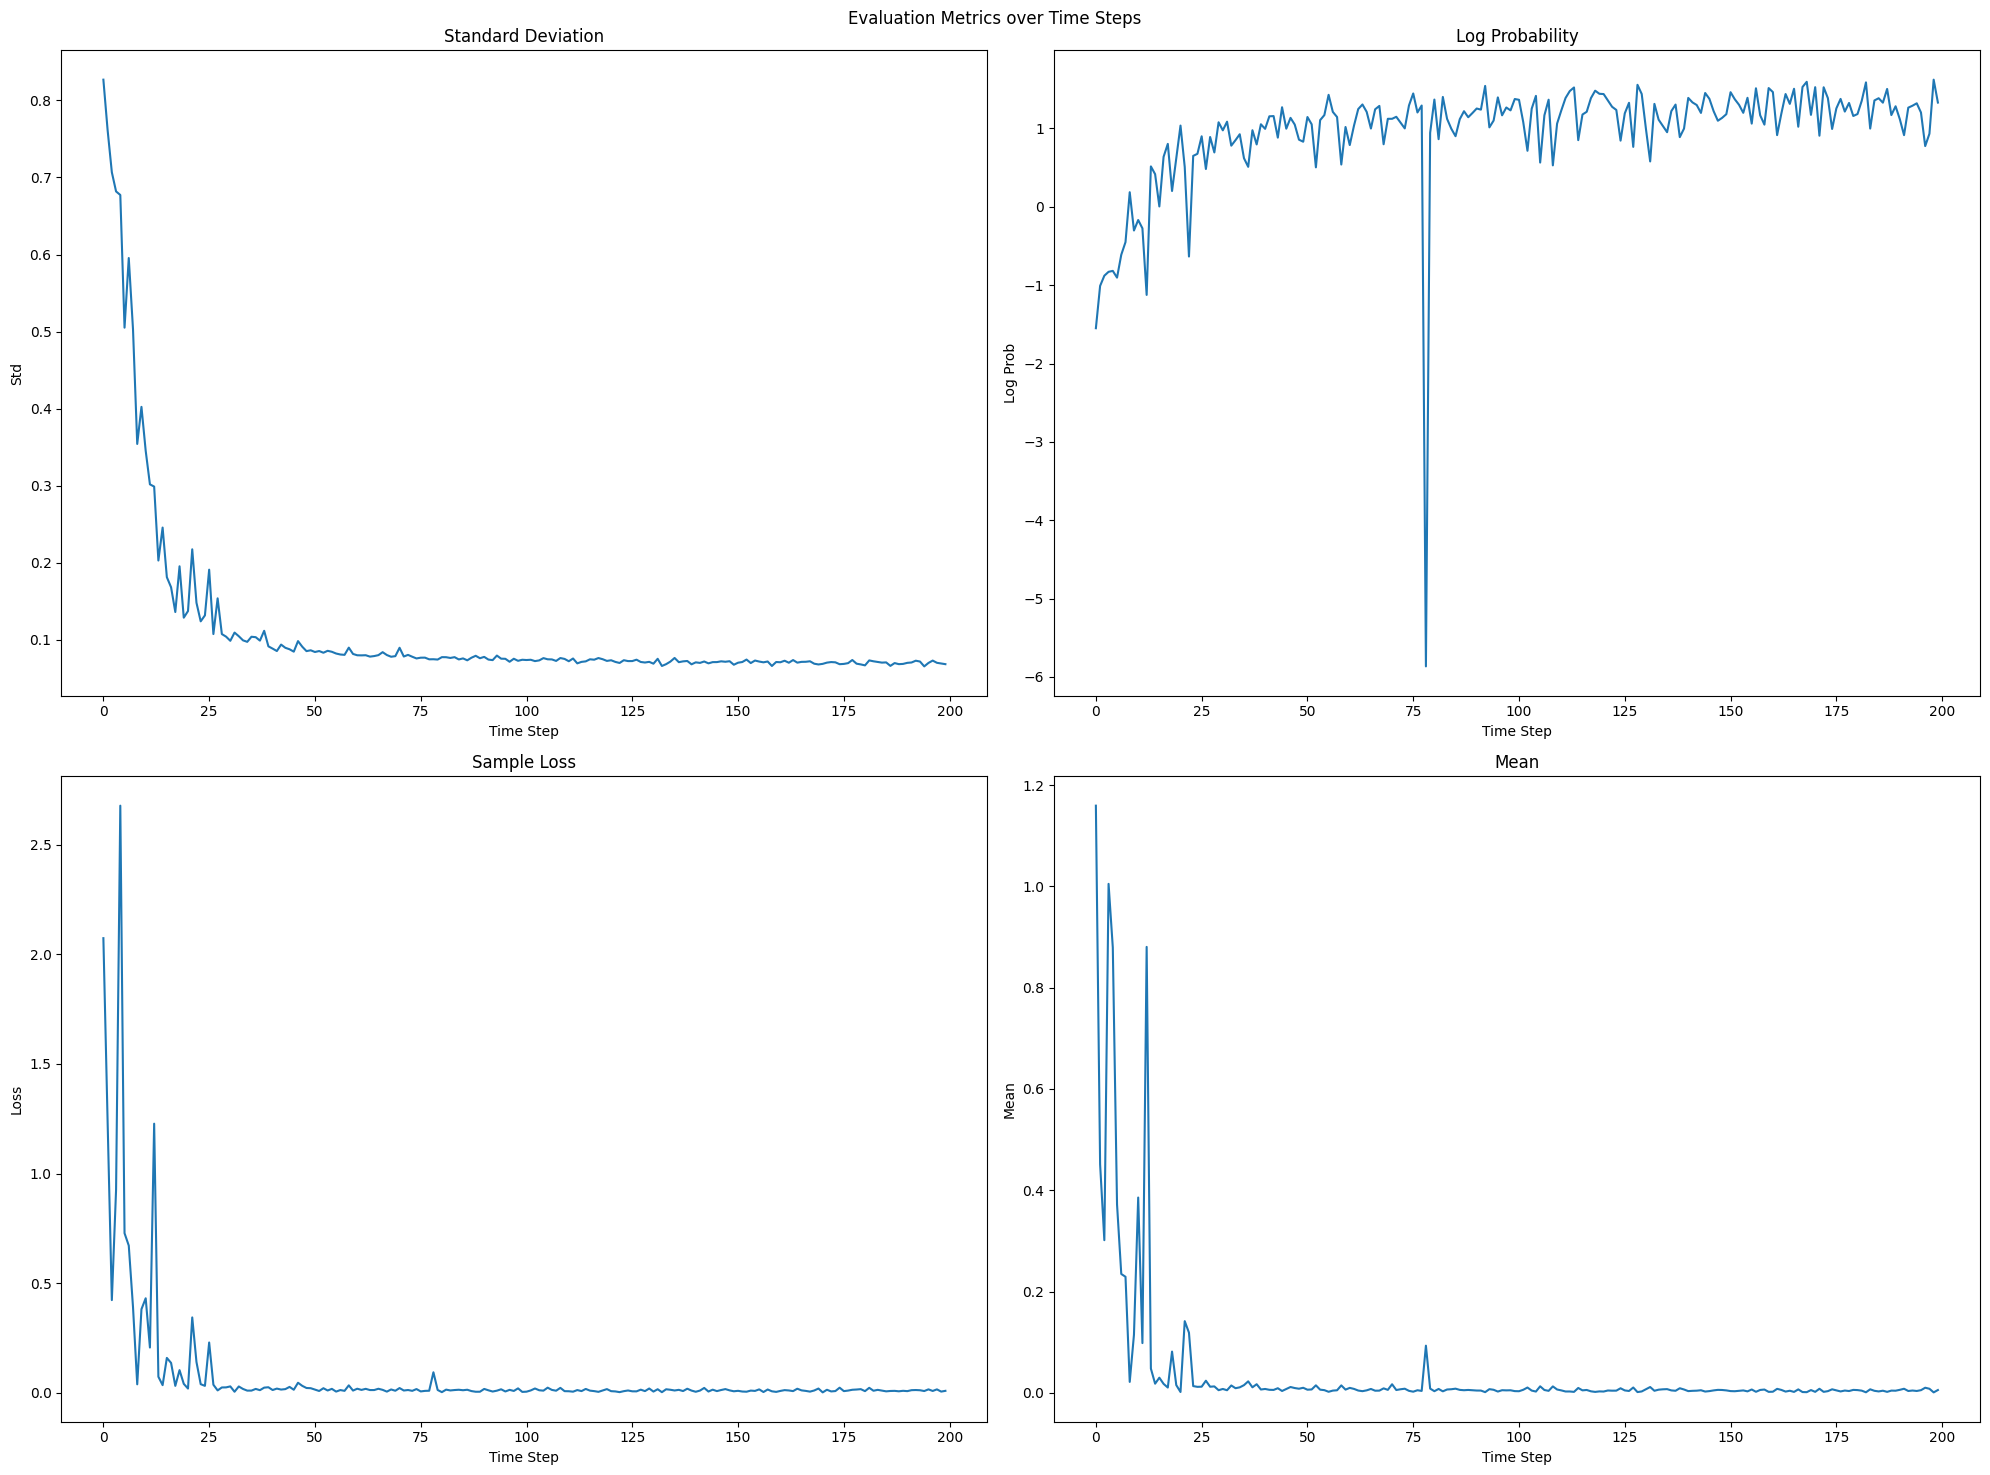

Average Standard Deviation: 0.0717
Average Log Probability: 1.2689
Average Sample Loss: 0.0148
Average Mean Loss: 0.0079


In [64]:
# plot all the lists on different subplots

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Evaluation Metrics over Time Steps')

# Plot std_list
axs[0, 0].plot(std_list_1.cpu().numpy())
axs[0, 0].set_title('Standard Deviation')
axs[0, 0].set_xlabel('Time Step')
axs[0, 0].set_ylabel('Std')

# Plot log_prob_list
axs[0, 1].plot(log_prob_list_1.cpu().numpy())
axs[0, 1].set_title('Log Probability')
axs[0, 1].set_xlabel('Time Step')
axs[0, 1].set_ylabel('Log Prob')

# Plot sample_loss_list
axs[1, 0].plot(sample_loss_list_1.cpu().numpy())
axs[1, 0].set_title('Sample Loss')
axs[1, 0].set_xlabel('Time Step')
axs[1, 0].set_ylabel('Loss')

# Plot mean_list
axs[1, 1].plot(mean_list_1.cpu().numpy())
axs[1, 1].set_title('Mean')
axs[1, 1].set_xlabel('Time Step')
axs[1, 1].set_ylabel('Mean')

plt.tight_layout()
plt.show()

# Print average metrics
print(f"Average Standard Deviation: {std_mean.item():.4f}")
print(f"Average Log Probability: {log_prob_mean.item():.4f}")
print(f"Average Sample Loss: {sample_loss_mean.item():.4f}")
print(f"Average Mean Loss: {mean_loss_mean.item():.4f}")


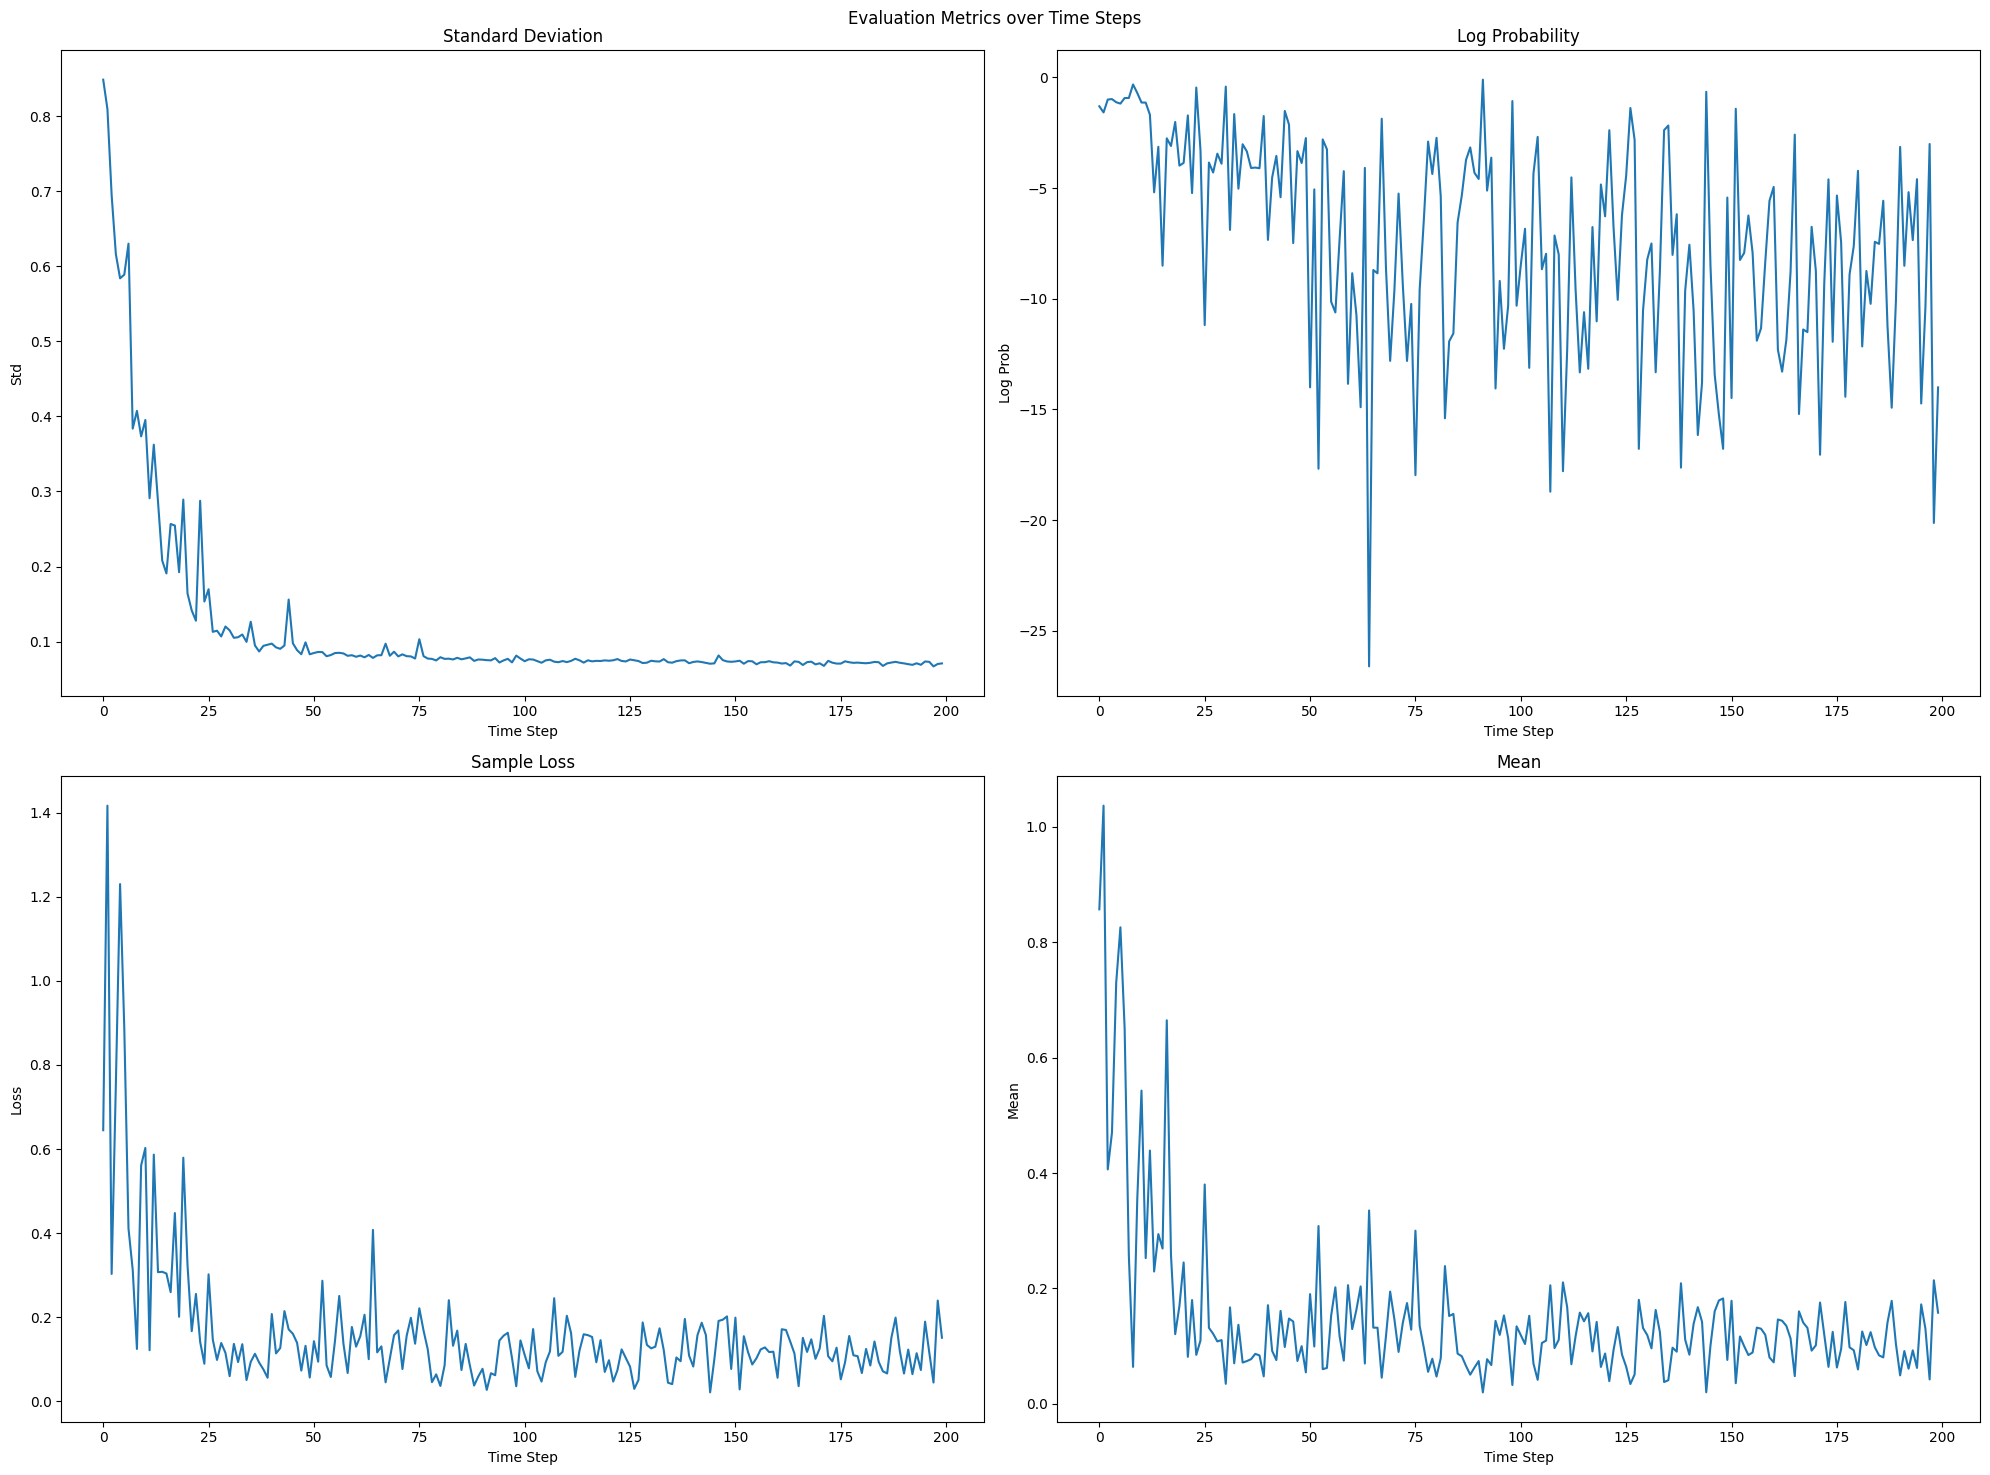

Average Standard Deviation: 0.1173
Average Log Probability: -7.4721
Average Sample Loss: 0.1632
Average Mean Loss: 0.1495


In [42]:
# plot all the lists on different subplots

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Evaluation Metrics over Time Steps')

# Plot std_list
axs[0, 0].plot(std_list.cpu().numpy())
axs[0, 0].set_title('Standard Deviation')
axs[0, 0].set_xlabel('Time Step')
axs[0, 0].set_ylabel('Std')

# Plot log_prob_list
axs[0, 1].plot(log_prob_list.cpu().numpy())
axs[0, 1].set_title('Log Probability')
axs[0, 1].set_xlabel('Time Step')
axs[0, 1].set_ylabel('Log Prob')

# Plot sample_loss_list
axs[1, 0].plot(sample_loss_list.cpu().numpy())
axs[1, 0].set_title('Sample Loss')
axs[1, 0].set_xlabel('Time Step')
axs[1, 0].set_ylabel('Loss')

# Plot mean_list
axs[1, 1].plot(mean_list.cpu().numpy())
axs[1, 1].set_title('Mean')
axs[1, 1].set_xlabel('Time Step')
axs[1, 1].set_ylabel('Mean')

plt.tight_layout()
plt.show()

# Print average metrics
print(f"Average Standard Deviation: {std_mean.item():.4f}")
print(f"Average Log Probability: {log_prob_mean.item():.4f}")
print(f"Average Sample Loss: {sample_loss_mean.item():.4f}")
print(f"Average Mean Loss: {mean_loss_mean.item():.4f}")



